# Búsqueda automática de imágenes usando una CNN para entrenar una GAN

La parte del entrenamiento de una red siempre es la tarea más compleja, no basta con encontrar aquellos parámetros que mejor converjan, además el dataset debe ser lo suficientemente grande para que esta generalice bien.

Con este proyecto se pretende alimentar a una GAN con imágenes de la serie "Los Simpson". Para crear el dataset se usarán dos fuentes de datos:

- El conjunto de rostros de los simpsons disponible en Kaggle: [Link](https://www.kaggle.com/kostastokis/simpsons-faces) con más de 7000 imágenes

- Google Images. Mediante web scraping se obtendrán más imágenes para el dataset

Si solo usasemos para entrenar la GAN el dataset de Kaggle tendríamos poca variabilidad de personajes ya que estas imágenes han sido extraídas de los capítulos de la serie entonces los personajes predominantes en este conjunto serán Marge, Lisa, Bart, Homer, etc. Esto mismo haría que la GAN aprendiese muy bien a recrear a estos personajes principales pero no a los Simpsons. Es por ello que es necesario aumentar el tamaño de nuestro conjunto de imágenes con personajes más variados usando web scraping (o image scraping).

La parte del web scraping se dividirá en dos fases:

- Obtener una lista de los personajes que se añadirán
- Buscar en google images $N$ imágenes de cada personaje, si estas imágenes contienen realmente un personaje de los Simpsons se añadirán al dataset con el preprocesado correspondiente sino se descartarán aquellas que no lo contengan

Para determinar si una imagen contiene a un personaje de Los Simpsons o no se entrenará a una CNN que nos servirá para discriminar en el conjunto de imágenes obtenidas de internet. Aquellas imágenes que contengan a un personaje se pasarán por un modelo de reconocimiento de rostros simpsons que nos devolverá tantas imágenes de rostros como personajes haya en la fotografía que le pasemos.

Un pequeño resumen de la estructura que seguiremos:

![texto alternativo](https://i.pinimg.com/originals/50/cb/25/50cb25815921afdc1c31c2a77685dd56.png)

## Índice

- [CNN Simpsons discriminator](#CNN-Simpsons-discriminator)
  - [Librerías](#Librerías)
  - [Dataframes](#Dataframes)
  - [Muestra](#Muestra)
  - [Modelo](#Modelo)
    - [Compilation](#Compilation)
    - [Training](#Training)
    - [Visualization](#Visualization)
    - [Evaluation](#Evaluation)
  - [Resultados](#Resultados)

- [Web Scraping](#Web-Scraping)
  - [Personajes Simpsons](#Personajes-Simpsons)
  - [Búsqueda automática de personajes](#Búsqueda-automática-de-personajes)
    - [Evaluación](#Evaluación)
  - [Subida de imágenes a google drive](#Subida-de-imágenes-a-google-drive)

- [DCGAN](#DCGAN)
  - [Librerías](#Librerías)
  - [Dataframe](#Dataframe)
  - [Muestra](#Muestra)
  - [Image Data Generator](#Image-Data-Generator)
  - [¿Qué es una DCGAN?](#¿Qué-es-una-DCGAN?)
  - [Modelo](#Modelo)
    - [Generador](#Generador)
    - [Discriminador](#Discriminador)
    - [GAN](#GAN)
    - [Plot functions](#Plot-functions)
    - [Training](#Training)
  - [Simpsons generados](#Simpsons-generados)
  
- [Referencias](#Referencias)

#CNN Simpsons discriminator
[[back to top](#Índice)]

Esta CNN se encargará de identificar si la imagen que le pasamos es un personaje de los Simpsons o no lo es. Para ello se usará la red del estado del arte VGG-16 preentrenada con los pesos de imagenet, esta técnica se conoce como transfer learning. La idea de este concepto es inicializar a una red predefinida con unos pesos que clasifican bien para un determinado dataset y adaptarlos a nuestro problema.

##Librerías
[[back to top](#Índice)]

In [0]:
from keras.applications import imagenet_utils
from tensorflow.keras import optimizers
from keras.layers import Dropout, Flatten, Dense
import matplotlib.pyplot as plt
from keras.engine import Model
from sklearn.metrics import classification_report
import numpy as np
from glob import glob
import os
import pandas as pd
from io import BytesIO
from keras.preprocessing.image import load_img
import numpy as np
from keras.preprocessing.image import img_to_array
from sklearn.model_selection import train_test_split
from keras.datasets import cifar10
from PIL import Image
import requests

Using TensorFlow backend.


In [0]:
from google.colab import drive
drive.mount('/content/drive', force_remount=False)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


<br>
<br>

## Dataframes
[[back to top](#Índice)]

Para entrenar a esta red se usarán dos datasets diferentes, uno contiene imágenes de personajes de los simpsons de tamaño 128x128 y el otro se compone de 60000 imágenes RGB de dimensiones 32x32 pertenecientes a 10 clases distintas (aviones, automóviles, pájaros, gatos, perros, ranas, caballos, barcos, etc.).  La siguiente función *carga_datos* servirá para:

- Cargar el dataset *cifar10*
- Normalizar las imágenes, reescalarlas a un tamaño 32x32 y añadirlas a la lista *images_list_train* así como ir creando un *ground_truth* donde las imágenes de los personajes de los simpsons estarán etiquetadas con un 1 mientras que las demás estarán etiquetadas con un 0
- Devolver las dos listas anteriores transformadas en arrays

Debido a la gran cantidad de datos y a la capacidad limitada de los servidores de google únicamente nos traeremos 5000 imágenes: 2500 serán de los simpsons mientras que la otra mitad pertenecerán al dataset cifar10.

In [0]:
dest_img = "/content/drive/My Drive/SIMPSONS FACES"
def carga_datos(destination, size):
  #Imágenes de cifar_10
  (X_train, y_train), _ = cifar10.load_data()

  images_list_train = []
  ground_truth = []

  # Obtenemos la dirección de las imágenes
  imgs = glob(os.path.join(destination, '*.png'))
  for direccion in imgs[:size // 2]:
    image = load_img(direccion, target_size=(32, 32))
    image = img_to_array(image)
    image = image / 255.0
    images_list_train.append(image)
    ground_truth.append(1)
  print("[INFO] Simpsons cargados")

  for image in X_train[:size // 2]:
    image = image / 255.0
    images_list_train.append(image)
    ground_truth.append(0)
  print("[INFO] Cifar10 cargado")

  return np.array(images_list_train), np.array(ground_truth)

train, ground_truth = carga_datos(dest_img, 3000)

170500096/170498071 [==============================] - 6s 0us/step
[INFO] Simpsons cargados
[INFO] Cifar10 cargado


In [0]:
#Cross validation -> Generamos un dataset de training y otro de test
X_train, X_test, y_train, y_test = train_test_split(train, ground_truth, test_size=0.15, random_state=None)

<br>
<br>

## Muestra
[[back to top](#Índice)]

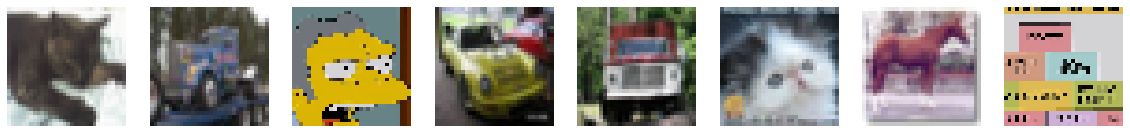

In [0]:
number = 8
sample_images = X_train[:number]

def show_samples(sample_images):
    figure, axes = plt.subplots(1, len(sample_images), figsize = (20, 20))
    for index, axis in enumerate(axes):
        axis.axis('off')
        image_array = sample_images[index]
        axis.imshow(image_array)
    plt.show()
    plt.close()

show_samples(sample_images)

<br>
<br>

## Modelo
[[back to top](#Índice)]

Shallow-tuning -> Modificamos únicamente el top model y reentrenamos en la etapa de clasificación. Estableceremos un top-model propio para este conjunto de datos. El base-model se mantendrá congelado.

In [0]:
from keras.applications import VGG16

# Dimensiones
input_shape = (32, 32, 3)

# Instanciamos el modelo con los pesos de imagenet pero sin incluir la parte de clasificación
base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

# Congelamos todas las capas del base-model --> Shallow-tuning
for layer in base_model.layers: 
  layer.trainable = False
  #print('Capa ' + layer.name + ' congelada...')

# Añadimos el top model en este caso serán capas FC
last = base_model.layers[-1].output
x = Flatten()(last)
x = Dense(1000, activation='relu', name='fc1')(x)
x = Dropout(0.3)(x)
x = Dense(200, activation='relu', name='fc2')(x)
x = Dense(2, activation='softmax', name='predictions')(x)
model_vgg = Model(base_model.input, x)
model_vgg.summary()





58892288/58889256 [==============================] - 2s 0us/step







Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________


<br>

### Compilation

In [0]:
# Compilamos el modelo
model_vgg.compile(loss='sparse_categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

<br>

### Training

In [0]:
# Lo entrenamos
H = model_vgg.fit(x=X_train, y=y_train, validation_split=0.2, batch_size=256, epochs=30, verbose=1)
model_vgg.save('simpson_model.h5')

Train on 2040 samples, validate on 510 samples
Epoch 1/30
2040/2040 [==============================] - 1s 384us/step - loss: 0.0280 - acc: 0.9917 - val_loss: 0.0227 - val_acc: 0.9922
Epoch 2/30
2040/2040 [==============================] - 1s 344us/step - loss: 0.0265 - acc: 0.9922 - val_loss: 0.0225 - val_acc: 0.9922
Epoch 3/30
2040/2040 [==============================] - 1s 342us/step - loss: 0.0269 - acc: 0.9926 - val_loss: 0.0222 - val_acc: 0.9922
Epoch 4/30
2040/2040 [==============================] - 1s 344us/step - loss: 0.0294 - acc: 0.9912 - val_loss: 0.0220 - val_acc: 0.9922
Epoch 5/30
2040/2040 [==============================] - 1s 338us/step - loss: 0.0240 - acc: 0.9946 - val_loss: 0.0218 - val_acc: 0.9922
Epoch 6/30
2040/2040 [==============================] - 1s 344us/step - loss: 0.0287 - acc: 0.9902 - val_loss: 0.0216 - val_acc: 0.9922
Epoch 7/30
2040/2040 [==============================] - 1s 342us/step - loss: 0.0254 - acc: 0.9946 - val_loss: 0.0215 - val_acc: 0.9902
E

<br>

### Visualization

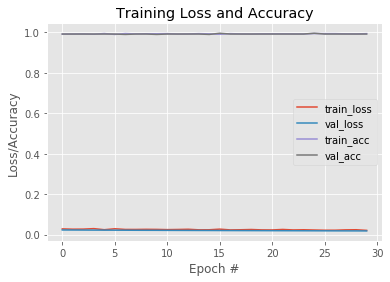

In [0]:
# Gráficas
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 30), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, 30), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, 30), H.history["acc"], label="train_acc")
plt.plot(np.arange(0, 30), H.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()

<br>

### Evaluation

In [0]:
print("[INFO]: Evaluando el modelo...")
score = model_vgg.evaluate(X_test, y_test, verbose=0)

print('Test loss:', score[0])
print('Accuracy:', score[1])

[INFO]: Evaluando el modelo...
Test loss: 0.02439153645135876
Accuracy: 0.9911111111111112


<br>
<br>

## Resultados
[[back to top](#Índice)]

In [0]:
def get_image_from_url(url):
    response = requests.get(url)
    img_print = Image.open(BytesIO(response.content)).resize((128,128))
    img_modelo = Image.open(BytesIO(response.content)).resize((32,32))
    img_print = np.array(img_print)
    img_modelo = np.array(img_modelo) /255.0
    img_modelo = np.expand_dims(img_modelo, axis=0)

    plt.figure(figsize = (24, 14))
    plt.subplot(1,4,1)
    plt.imshow(img_print)
    plt.grid(False)
    plt.title("Input")

    pred = model_vgg.predict(img_modelo)
    print("[INFO] Probabilidad de que sea un Simpson: {}%".format(pred[0][1]* 100))
    print("[INFO] Probabilidad de que no sea un Simpson: {}%".format(pred[0][0]* 100))
    plt.show()

[INFO] Probabilidad de que sea un Simpson: 26.28559172153473%
[INFO] Probabilidad de que no sea un Simpson: 73.71440529823303%


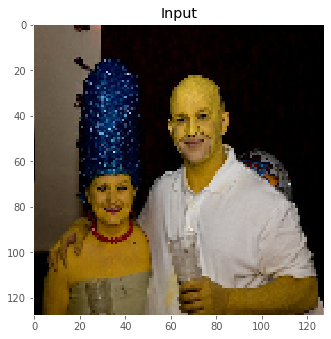

In [0]:
url = "http://mm.disfracesycarnaval.es/uploads/2012/03/disfraces-simpson-homer-marge.jpg"
get_image_from_url(url)

<br>
<br>

# Web Scraping
[[back to top](#Índice)]

El objetivo de la parte de web scraping es obtener imágenes de todos los personajes simpsons para que el entrenamiento de la GAN no esté tan sesgado.

Los pasos a seguir serán los siguientes:

- **[Personajes]** Obtener un listado con todos los personajes simpsons -> Quitando los 5 primeros (Marge, Lisa, Bart...)

- **[Links]** Para cada personaje buscar en google Images los links a los imágenes en buena calidad de las 30 primeras ocurrencias

- **[Simpson_p]** Crear un array de cada imagen redimensionada y pasar cada una por la CNN definida anteriormente para saber la probabilidad de que aparezca un Simpson, si esta es mayor que 0.5 la añadimos a la lista Simpson_p

- **[Recortes]** Usaremos la función *find_face()* para encontrar los rostros en las imágenes

- **[Subida]** Una vez se tengan recortadas todas las imágenes, estas se subirán a google drive


La función find_face() pertenece al siguiente repositorio: [Simpsons-Face-Detector](https://github.com/KostasTok/Simpsons-Face-Detector). Usaremos este código para obtener las imágenes ya recortadas. El proceso para obtener las caras se basa principalmente en identificar clusters de píxeles blancos que parezcan ojos, es por ello que no siempre acierta ya que los personajes no siempre siguen un patrón consistente.

<br>

## Librerías
[[back to top](#Índice)]

In [0]:
import requests
from bs4 import BeautifulSoup
import re
import face_detector as fd
from io import BytesIO
from PIL import Image, ImageEnhance
import numpy as np
import json
import matplotlib.pyplot as plt
from tensorflow import keras

#model_vgg = keras.models.load_model('simpson_model.h5')

## Personajes Simpsons
[[back to top](#Índice)]

Líneas:

- **[1-3]** Crear una "sopa" con los módulos *BeautifulSoup* y *Requests* de la página de Wikipedia que contiene tablas donde se encuentran todos los personajes que aparecen en Los Simpsons

- **[5]** Variable tabla que contiene la tabla donde aparecen los personajes en formato html. La tabla que buscamos es de la clase: "wikitable sortable"

- **[6]** Variable filas con todas las filas de la tabla

- **[7]** Variable td con el contenido de la columna que indica el nombre del personaje

Pseudocódigo:

```python
    function get_personajes(url):
        [0] crear sopa
        [1] crear lista_personajes
        [2] encontrar tabla con class_ = wikitable sortable
            para cada fila en tabla
              [3] encontrar primera etiqueta td
              [4] personaje = contenido etiqueta a
              [5] añadir personaje a lista_personajes

        devolver lista_personajes

```

In [0]:
def get_personajes(url):
  
  src = requests.get(url)
  soup = BeautifulSoup(src.content, "lxml")

  personajes = []
  table = soup.find("table", class_="wikitable sortable")
  filas = table.find_all('tr')
  for fila in filas:
    td = fila.find("td")
    try:
      personaje = td.find("a").text
      personajes.append(personaje)
    except:
      pass

  return personajes

url = "https://en.wikipedia.org/wiki/List_of_The_Simpsons_characters"
personajes = get_personajes(url)

In [0]:
personajes

['Homer Simpson',
 'Marge Simpson',
 'Bart Simpson',
 'Lisa Simpson',
 'Maggie Simpson',
 'Akira',
 'Ms. Albright',
 'Aristotle Amadopolis',
 'Atkins, State Comptroller',
 'Mary Bailey',
 'Birchibald "Birch" T. Barlow',
 'Jasper Beardly',
 'Benjamin, Doug, and Gary',
 'Bill and Marty',
 'Blinky',
 'Blue Haired Lawyer',
 'Boobarella',
 'Wendell Borton',
 'Jacqueline Bouvier',
 'Patty Bouvier',
 'Selma Bouvier',
 'Kent Brockman',
 'Bumblebee Man',
 'Charles Montgomery Burns',
 'Capital City Goofball',
 'Carl Carlson',
 'Crazy Cat Lady',
 'Gary Chalmers',
 'Charlie',
 'Chase (Pyro)',
 'Scott Christian',
 'Comic Book Guy',
 'Mr. Costington',
 'Database',
 'Declan Desmond',
 'Disco Stu',
 'Dolph',
 'Lunchlady Doris',
 'Duffman',
 'Eddie and Lou',
 'Fat Tony',
 'Maude Flanders',
 'Ned Flanders',
 'Rod Flanders',
 'Todd Flanders',
 'Francesca',
 'Frankie the Squealer',
 'Professor John Frink',
 'Baby Gerald',
 'Gino Terwilliger',
 'Alice Glick',
 'Gloria Jailbird',
 'Barney Gumble',
 'Gil Gun

In [0]:
personajes = personajes[5:]
print("[INFO] Hay {} personajes".format(len(personajes)))

[INFO] Hay 139 personajes


<br>
<br>

## Búsqueda automática de personajes
[[back to top](#Índice)]

Pseudocódigo:


```python
      function get_simpsons(personajes, number_images = 30):
        [0] Creamos lista donde se guardan las imágenes finales
        para cada personaje en personajes
          [1] Url = búsqueda en google de personaje + "Simpsons Face"
          [2] Abrir session (método requests)
          [3] Actualizar headers de la session
          [4] Guardamos el html devuelto por la url
          [5] Creamos una sopa del html devuelto
          [6] De la sopa nos quedamos con las etiquetas de la clase: "rg_meta.notranslate"
          # Estas etiquetas contienen un objeto json donde el elemento ["ou"] contiene el link a las imágenes en buena calidad
          [7] Iteramos sobre todas las etiquetas y nos quedamos con el elemento "ou" de su json que añadimos en una 
          lista -> Donde se guardan todos los links
          [8] Creamos lista donde guardar las imágenes escogidas
          para cada link en links
            [9] Guardamos lo que nos devuelve el link en response -> Imagen codificada en Bytes
            [10] Abrimos la imagen
            [11] Creamos una copia de la imagen que redimensionamos a un tamaño 32x32 que se le pasará a la CNN
            [12] Se le pasa la imagen a la CNN -> Si se predice que es un simpson con una probabilidad > 0.5 -> Se añade a la lista[8]
          
          [13] Creamos lista donde guardar los recortes
          para cada imagen en escogidas [8]
            [14] Le pasamos a find_face() la imagen que nos devuelve los recortes que se añaden a la lista [13]
          [15] Se añaden los recortes a lista [0]
          [16] Se imprime información sobre cada personaje
          
  devolver imágenes finales[0]
```

In [0]:
def get_simpsons(personajes, number_images = 30):
  lista_simpson = []
  for personaje in personajes:
    c = "{} Simpsons face".format(personaje)
    url = "https://www.google.com/search?q={}&tbm=isch".format(c)
    ses = requests.session()
    ses.headers.update(
        {
      "User-Agent":"Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/78.0.3904.108 Safari/537.36"
    }
    )
    html = ses.get(url)
    soup = BeautifulSoup(html.content)
    elements = soup.find_all("div", class_ = "rg_meta notranslate")
    links = [json.loads(etiqueta.text)["ou"] for etiqueta in elements]  # 100 links

    simpson_p = []
    for link_img in links[:number_images]:
      try:
        response = requests.get(link_img)
        img = Image.open(BytesIO(response.content))
        img_modelo = Image.open(BytesIO(response.content)).resize((32,32))
        
        img = np.array(img)
        if len(img.shape) == 3 and img.shape[2] == 3 and img.shape[0]*img.shape[1] < 1843200:
          img_modelo = np.array(img_modelo) / 255.0
          img_modelo = np.expand_dims(img_modelo, axis=0)
          pred = model_vgg.predict(img_modelo)
          if pred[0][1] > 0.5:
            simpson_p.append(img)
      except:
        pass

    recortes = []
    for simpson in simpson_p:
      try:
        windows_images, _ = fd.find_face(simpson)
        for i in windows_images:
          recortes.append(i)
      except:
        pass
    for recorte in recortes:
      lista_simpson.append(recorte)
    print("[INFO] Se han detectado {} imágenes de {}; Válidas: {}".format(len(simpson_p), personaje, len(recortes)))
  return lista_simpson

In [0]:
%%time
imagenes_google = get_simpsons(personajes, 40)

/content/cluster_info.py:69: RuntimeWarning: divide by zero encountered in long_scalars
  if points_count/area > min_density: # density test


[INFO] Se han detectado 22 imágenes de Akira; Válidas: 1
[INFO] Se han detectado 13 imágenes de Ms. Albright; Válidas: 2
[INFO] Se han detectado 16 imágenes de Aristotle Amadopolis; Válidas: 1
[INFO] Se han detectado 11 imágenes de Atkins, State Comptroller; Válidas: 3
[INFO] Se han detectado 13 imágenes de Mary Bailey; Válidas: 5
[INFO] Se han detectado 0 imágenes de Birchibald "Birch" T. Barlow; Válidas: 0
[INFO] Se han detectado 0 imágenes de Jasper Beardly; Válidas: 0
[INFO] Se han detectado 22 imágenes de Benjamin, Doug, and Gary; Válidas: 2
[INFO] Se han detectado 19 imágenes de Bill and Marty; Válidas: 8
[INFO] Se han detectado 21 imágenes de Blinky; Válidas: 4
[INFO] Se han detectado 0 imágenes de Blue Haired Lawyer; Válidas: 0
[INFO] Se han detectado 17 imágenes de Boobarella; Válidas: 7
[INFO] Se han detectado 13 imágenes de Wendell Borton; Válidas: 3
[INFO] Se han detectado 0 imágenes de Jacqueline Bouvier; Válidas: 0
[INFO] Se han detectado 19 imágenes de Patty Bouvier; Vál

<br>

### Evaluación

In [0]:
print("[INFO] Se han extraído {} imágenes".format(len(imagenes_google)))

[INFO] Se han extraído 514 imágenes


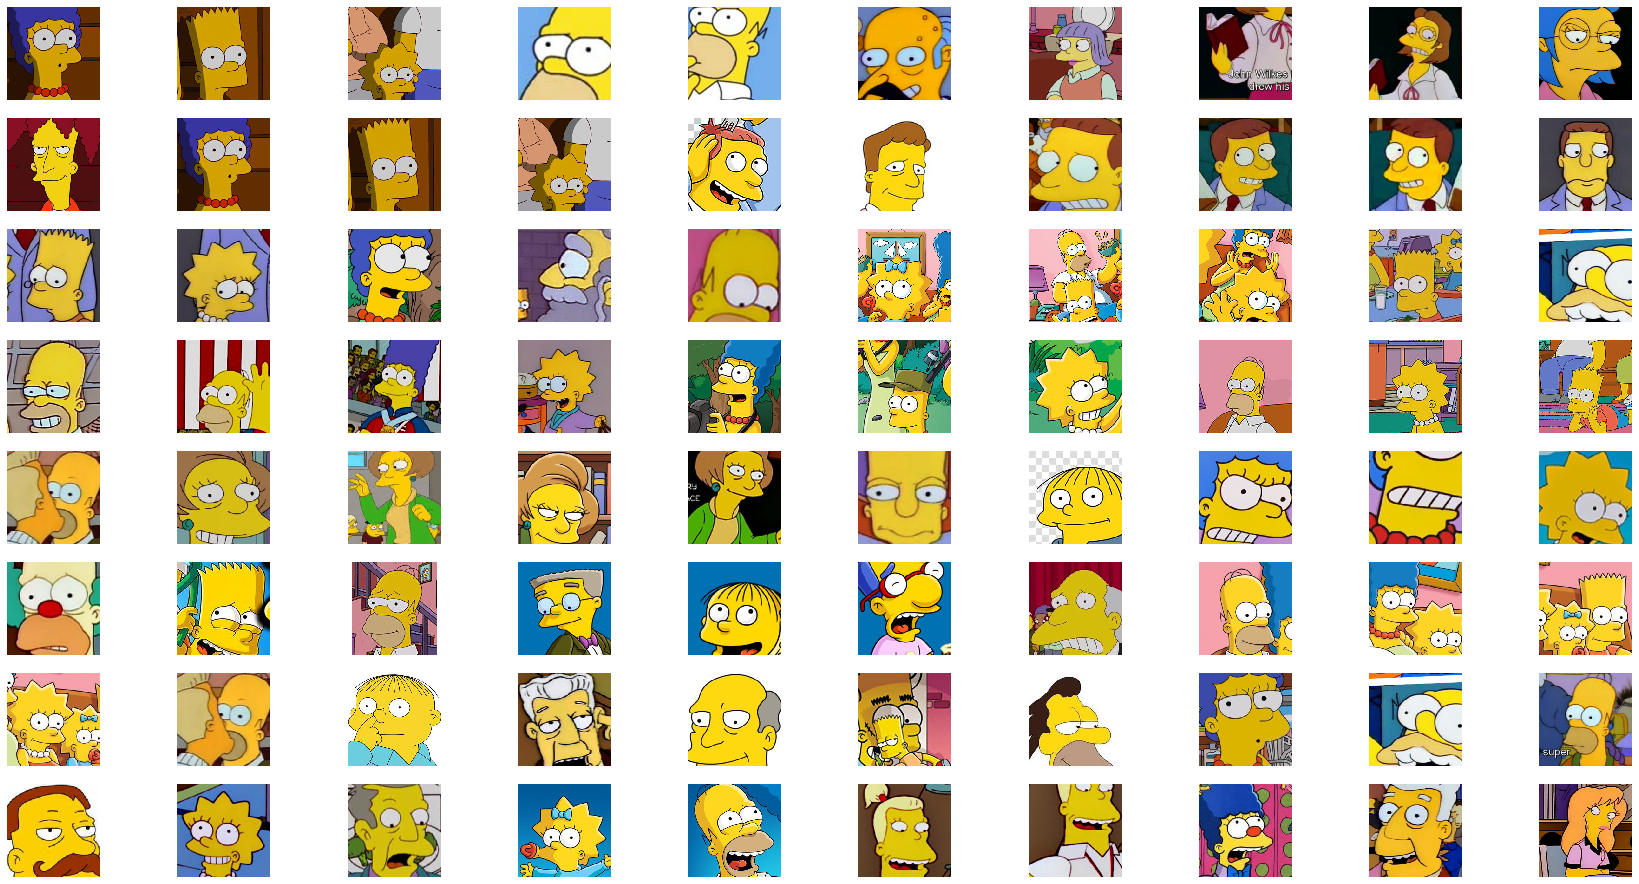

In [0]:
def show_samples(sample_images):
  fig, ax = plt.subplots(nrows=8, ncols=10, figsize = (30, 16))
  i = 0
  for row in ax:
      for col in row:
        col.axis('off')
        col.imshow(sample_images[i])
        i += 1

  plt.show()

show_samples(imagenes_google[200:])

<br>
<br>

## Subida de imágenes a google drive
[[back to top](#Índice)]

In [0]:
#OJO, LAS IMÁGENES TIENEN QUE GUARDARSE EN FORMATO PNG
def drive_upload(images, folder, etiqueta):
  for i, image in enumerate(images):
    if i % 50 == 0:
      print("[INFO] {} uploaded".format(i))
    img = Image.fromarray(image)
    c = "{}{}.png".format(etiqueta, i)
    img.save("{}{}".format(folder, c))

In [0]:
folder = "/content/drive/My Drive/SIMPSONS FACES/"
etiqueta = "g"
drive_upload(imagenes_google, folder, etiqueta)

[INFO] 0 uploaded
[INFO] 50 uploaded
[INFO] 100 uploaded
[INFO] 150 uploaded
[INFO] 200 uploaded
[INFO] 250 uploaded
[INFO] 300 uploaded
[INFO] 350 uploaded
[INFO] 400 uploaded
[INFO] 450 uploaded
[INFO] 500 uploaded


<br>
<br>

# DCGAN
[[back to top](#Índice)]

## Librerías
[[back to top](#Índice)]

In [0]:
import random
from keras.models import Sequential, Model
from keras.layers import Lambda, LeakyReLU, Reshape, Add, Cropping2D, Conv2DTranspose, Permute, Conv2D, MaxPooling2D, Activation, BatchNormalization
from keras import backend as K
from keras.layers.core import Dense, Flatten
from keras.optimizers import Adam
from keras.layers import Input
import tensorflow as tf
import time
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD
from keras.applications.vgg16 import VGG16
from keras.utils import get_file
import keras
import shutil
import os
from glob import glob
import pandas as pd

<br>
<br>

## Dataframe
[[back to top](#Índice)]

Necesitaremos crear un dataframe con una columna:

* El nombre de los archivos .png

Para poder usar flow_from_dataframe en nuestro generador.

In [0]:
dest_img = "/content/drive/My Drive/SIMPSONS FACES"

# Obtenemos en dos listas los nombres de los archivos
imgs = sorted([os.path.basename(i) for i in glob(os.path.join(dest_img, '*.png'))])

In [0]:
# Creamos el dataframe donde la columna será la lista anterior
df = pd.DataFrame({'image_filename':imgs})
df.head()

image_filename
0          1.png
1         10.png
2        100.png
3       1000.png
4       1001.png

<br>
<br>

## Muestra
[[back to top](#Índice)]

Vamos a mostrar algunas imágenes del dataset.

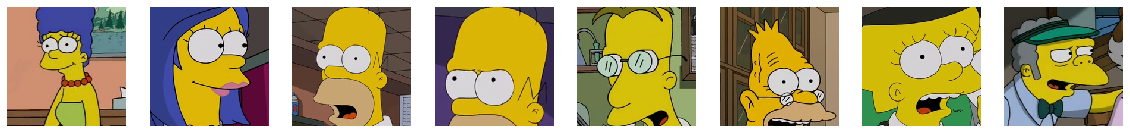

In [0]:
number = 8
dest_img = "/content/drive/My Drive/SIMPSONS FACES"
sample_images = [np.array(Image.open(os.path.join( dest_img, df['image_filename'].iloc[random.randint(0,5000)]))) for i in range(number)]


def show_samples(sample_images):
    figure, axes = plt.subplots(1, len(sample_images), figsize = (20, 20))
    for index, axis in enumerate(axes):
        axis.axis('off')
        image_array = sample_images[index]
        axis.imshow(image_array)
        image = Image.fromarray(image_array)
    plt.show()
    plt.close()

show_samples(sample_images)

<br>
<br>

## Image Data Generator
[[back to top](#Índice)]

Keras es una librería de alto nivel que le permite a cualquiera crear modelos de deep learning en minutos. Esta cuenta con la clase ImageDataGenerator que nos permite realizar data augmentation "sobre la marcha" de una forma muy simple.

La clase ImageDataGenerator tiene tres métodos: flow(), flow_from_directory() y flow_from_dataframe() para leer las imágenes. En este caso usaremos flow_from_dataframe() para crear la función image_generator que nos devolverá un train_generator que será llamado a la hora de entrenar a nuestro modelo.

In [0]:
# Ruta imagen alatoria
img_path = "/content/drive/My Drive/SIMPSONS FACES/1.png"
# Directorio de las imágenes
img_directory = "/content/drive/My Drive/SIMPSONS FACES"

def image_generator(df, img_path, img_directory):

    """Adaptado de @aaronphilip. Función para crear un generador de imágenes
    https://keras.io/preprocessing/image/#imagedatagenerator-class

    Argumentos:

        df: dataframe
        img_path (str): path de una imagen aleatoria
        img_directory (str): path del directorio que contiene las imágenes
    
    Devuelve:
        Un generator
    """

    # Para el data augmentation simplemente haremos un volteado horizontal de las imágenes

    image_datagen = ImageDataGenerator(
                     horizontal_flip=True
                     )
  
    seed=1
    image_datagen.fit(np.expand_dims(np.asarray(Image.open(img_path)), axis=0), augment=True, seed=seed)

    image_generator = image_datagen.flow_from_dataframe(
        dataframe = df,
        directory = img_directory,
        x_col = 'image_filename',
        y_col = None,
        class_mode=None,
        seed=1,
        batch_size=BATCH_SIZE,
        target_size=(64,64)
        )

    return image_generator

train_generator = image_generator(df, img_path, img_directory)

Found 8164 validated image filenames.


<br>
<br>

## ¿Qué es una DCGAN?
[[back to top](#Índice)]

La DCGAN es uno de los más populares y existosos diseños de GAN's. Se compone básicamente de capas convolucionales sin max pooling o de capas fully connected. Utiliza los strides de las capas convolucionales y deconvoluciones para la parte de "downsampling" y "upsampling". En la siguiente figura podemos ver la parte del generador.

Una de las partes más interesantes de una GAN es el diseño del generador. La red generadora es capaz de tomar un vector aleatorio de números y convertirlo en una imagen de tal forma que el discriminador no pueda distinguir si esta es real o no.

![Figura 1](https://cdn-images-1.medium.com/max/800/1*rdXKdyfNjorzP10ZA3yNmQ.png)


En este notebook veremos implementada una DCGAN en keras. La parte del generador fue propuesto originalmente en el paper [LSUN: Construction of a Large-scale Image Dataset using Deep Learning with Humans in the Loop](https://arxiv.org/pdf/1506.03365.pdf). Este generador toma un vector aleatorio de 100x1 (z) y lo transforma en un otput que será una imagen de dimensiones 64x64x3.

Podemos ver en la figura que el generador usa capas convolucionales clásicas que transforman el output a unas dimensiones que siguen la clásica ecuación: (N+ P - F)/S + 1. Podemos observar que el parámetro N va de 4 a 8, 16 y 32 pero sin alterar el tamaño del kernel que siempre es de 5x5 ni el stride que es de 2. Además no existe ningún padding. **¡Simple pero eficaz!**

Aquí unos apectos claves para diseñar la red:
* Reemplazar el max pooling por el stride de las capas convolucionales
* Usar deconvoluciones para la parte de upsampling (generador)
* Eliminar las capas fully-connected
* Usar Batch Normalization en todas las capas excepto en la salida del generador y en la entrada del discriminador
* Usar ReLUs en el generador excepto en la salida donde se usa tanh (tangente hiperbólica) como función de activación
* Usar LeakyReLUs en el discriminador



---


Algunos consejos del paper:

>> Todos los modelos fueron entrenados con "mini-batch stochastic gradient descent (SGD)" con un tamaño de batch de 128. Todos los pesos fueron inicializados con una distribución Normal con una desviación típica de 0.02. En la LeackyReLU el alpha fue inicializado a 0.2 en todos los modelos. También usamos el optimizador Adam con los siguientes hiperparámetros; vimos que un lr de 0.001 era demasiado alto así que usamos 0.0002. Además, vimos que un momentum de 0.5 y no de 0.9 ayudaba a estabilizar el entrenamiento.

<br>
<br>

## Modelo
[[back to top](#Índice)]

In [0]:
# HIPERPARÁMETROS
NOISE_SIZE = 100
WEIGHT_INIT_STDDEV = 0.02
IMAGE_SIZE = 32
SAMPLES_TO_SHOW = 8
EPOCHS = 50
BATCH_SIZE = 64

<br>
<br>

### Generador

In [0]:
def generator_model(z):

  """Arquitectura del generador"""

  # 4 x 4 x 512
  input_layer = Input(z)
  hid = Dense(4*4*512, activation='relu', name ="Dense")(input_layer)    
  hid = LeakyReLU(alpha=0.2)(hid)
  hid = Reshape((4, 4, 512))(hid)

  # 4x4x512 -> 8x8x512
  hid = Conv2DTranspose(512, kernel_size=[5,5],
                               strides=[2,2],
                               padding="same",
                               kernel_initializer= keras.initializers.TruncatedNormal(stddev=WEIGHT_INIT_STDDEV),name ="trans_conv1")(hid)
  hid = BatchNormalization(momentum=0.9, epsilon=0.00005,name="batch_trans_conv1")(hid)
  hid = LeakyReLU(alpha=0.2,name ="trans_conv1_out")(hid)

  # 8x8x512 -> 16x16x256
  hid = Conv2DTranspose(256, kernel_size=[5,5],
                               strides=[2,2],
                               padding="same",
                               kernel_initializer= keras.initializers.TruncatedNormal(stddev=WEIGHT_INIT_STDDEV),name ="trans_conv2")(hid)
  hid = BatchNormalization(momentum=0.9, epsilon=0.00005,name="batch_trans_conv2")(hid)
  hid = LeakyReLU(alpha=0.2,name ="trans_conv2_out")(hid)
  
  # 16x16x256 -> 32x32x128
  hid = Conv2DTranspose(128, kernel_size=[5,5],
                               strides=[2,2],
                               padding="same",
                               kernel_initializer= keras.initializers.TruncatedNormal(stddev=WEIGHT_INIT_STDDEV),name ="trans_conv3")(hid)
  hid = BatchNormalization(momentum=0.9, epsilon=0.00005,name="batch_trans_conv3")(hid)
  hid = LeakyReLU(alpha=0.2,name ="trans_conv3_out")(hid)  

  # 32x32x128 -> 64x64x64
  hid = Conv2DTranspose(64, kernel_size=[5,5],
                               strides=[2,2],
                               padding="same",
                               kernel_initializer= keras.initializers.TruncatedNormal(stddev=WEIGHT_INIT_STDDEV),name ="trans_conv4")(hid)
  hid = BatchNormalization(momentum=0.9, epsilon=0.00005, name="batch_trans_conv4")(hid)
  hid = LeakyReLU(alpha=0.2,name ="trans_conv4_out")(hid)

  # 64x64x64 -> 64x64x3
  hid = Conv2DTranspose(3, kernel_size=[5,5],
                               strides=[1,1],
                               padding="same",
                               kernel_initializer= keras.initializers.TruncatedNormal(stddev=WEIGHT_INIT_STDDEV),name ="logits")(hid)

  out = Activation("tanh", name ="out")(hid)
  model = Model(inputs=input_layer, outputs=out)
  return model

<br>
<br>

### Discriminador

In [0]:
def discriminator_model(image_size, output_nc = 3 ):

  """Arquitectura del discriminador"""

  input_shape_discriminator = (image_size, image_size, output_nc)

  # 64x64x3 -> 32x32x32
  input_layer = Input(shape = input_shape_discriminator)
  hid = Conv2D(filters=32,
                    kernel_size=[5,5],
                    strides=[2,2],
                    padding="same",
                    kernel_initializer= keras.initializers.TruncatedNormal(stddev=WEIGHT_INIT_STDDEV),
                    name = "conv1")(input_layer)
  hid = BatchNormalization(momentum=0.9, epsilon=0.00005,name="batch_norm1")(hid)
  hid = LeakyReLU(alpha=0.2,name="conv1_out")(hid)  

  # 32x32x32-> 16x16x64 
  hid = Conv2D(filters=64,
                        kernel_size=[5,5],
                        strides=[2,2],
                        padding="same",
                        kernel_initializer= keras.initializers.TruncatedNormal(stddev=WEIGHT_INIT_STDDEV),
                        name = "conv2")(hid)
  hid = BatchNormalization(momentum=0.9, epsilon=0.00005,name="batch_norm2")(hid)
  hid = LeakyReLU(alpha=0.2,name="conv2_out")(hid)

  # 16x16x64  -> 8x8x128  
  hid = Conv2D(filters=128,
                    kernel_size=[5,5],
                    strides=[2,2],
                    padding="same",
                    kernel_initializer= keras.initializers.TruncatedNormal(stddev=WEIGHT_INIT_STDDEV),
                    name = "conv3")(hid)
  hid = BatchNormalization(momentum=0.9, epsilon=0.00005,name="batch_norm3")(hid)
  hid = LeakyReLU(alpha=0.2,name="conv3_out")(hid)

  # 8x8x128 -> 8x8x256
  hid = Conv2D(filters=256,
                    kernel_size=[5,5],
                    strides=[1,1],
                    padding="same",
                    kernel_initializer= keras.initializers.TruncatedNormal(stddev=WEIGHT_INIT_STDDEV),
                    name = "conv4")(hid)
  hid = BatchNormalization(momentum=0.9, epsilon=0.00005,name="batch_norm4")(hid)
  hid = LeakyReLU(alpha=0.2,name="conv4_out")(hid)

  # 8x8x256 -> 4x4x512
  hid = Conv2D(filters=512,
                    kernel_size=[5,5],
                    strides=[2,2],
                    padding="same",
                    kernel_initializer= keras.initializers.TruncatedNormal(stddev=WEIGHT_INIT_STDDEV),
                    name = "conv5")(hid)  
  hid = BatchNormalization(momentum=0.9, epsilon=0.00005,name="batch_norm5")(hid)
  hid = LeakyReLU(alpha=0.2,name="conv5_out")(hid)

  hid = Flatten(name = "flatten")(hid)
  out = Dense(1, activation='sigmoid', name = "out")(hid)
  model = Model(inputs= input_layer, outputs=out)

  return model

<br>
<br>

### GAN

In [0]:
#Discriminator
discriminator = discriminator_model(64, 3)
discriminator.compile(loss='binary_crossentropy',optimizer=Adam(lr=0.00004, beta_1=0.5),metrics=['accuracy'])

# For the combined model we will only train the generator
discriminator.trainable = False

#Generator
generator = generator_model((NOISE_SIZE,))

#GAN
# The discriminator takes generated images as input and determines validity
gan_input = Input(shape=(NOISE_SIZE,))
x = generator(gan_input)
gan_out = discriminator(x)
gan = Model(gan_input, gan_out)
gan.summary()

gan.compile(loss='binary_crossentropy',optimizer=Adam(lr=0.0004, beta_1=0.5))















Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 100)               0         
_________________________________________________________________
model_2 (Model)              (None, 64, 64, 3)         11691395  
_________________________________________________________________
model_1 (Model)              (None, 1)                 4367553   
Total params: 16,058,948
Trainable params: 11,689,475
Non-trainable params: 4,369,473
_________________________________________________________________


<br>
<br>

### Plot functions

In [0]:
def show_samples(sample_images, epoch):
    figure, axes = plt.subplots(1, len(sample_images), figsize = (16, 16))
    for index, axis in enumerate(axes):
        axis.axis('off')
        image_array = sample_images[index]
        axis.imshow(image_array)
        image = Image.fromarray(image_array)
    plt.show()
    plt.close()

def test(input_z, epoch):
    samples = generator.predict(input_z[:SAMPLES_TO_SHOW])
    sample_images = [((sample + 1.0) * 127.5).astype(np.uint8) for sample in samples]
    show_samples(sample_images, epoch)

def summarize_epoch(d_losses, g_losses, accuracy, epoch, duration, input_z):
    minibatch_size = int(len(df)//BATCH_SIZE)
    print("Epoch {}/{}".format(epoch, EPOCHS),
          "\nDuration: {:.5f}".format(duration),
          "\nD Loss: {:.5f}".format(np.mean(d_losses[-minibatch_size:])),
          "\nG Loss: {:.5f}".format(np.mean(g_losses[-minibatch_size:])),
          "\nD Accuracy: {:.3f}".format(100* np.mean(accuracy[-minibatch_size:])))
    fig, ax = plt.subplots()
    plt.plot(d_losses, label='Discriminator', alpha=0.6)
    plt.plot(g_losses, label='Generator', alpha=0.6)
    plt.plot(accuracy, label='Accuracy', alpha=0.6)
    plt.title("Losses")
    plt.legend()
    plt.show()
    plt.close()
    test(input_z, epoch)

<br>
<br>

### Training

In [0]:
def train(EPOCHS, batch_size):

  print("Number of batches: {}".format(len(df)//batch_size))

  d_losses = []
  g_losses = []
  cum_d_loss = 0
  cum_g_loss = 0
  accuracy = []

  for epoch in range(EPOCHS):
    epoch += 1
    start_time = time.time()
    BATCH_SIZE = batch_size
    for batch_images_ in range(len(df)//BATCH_SIZE):
        if batch_images_ % 20 == 0:
          print("[INFO] Batch {}".format(batch_images_))
        # ---------------------
        #  Train Discriminator
        # ---------------------
        batch_images = train_generator.next()
        batch_images = np.array([(i/127.5) - 1 for i in batch_images]) # Normailize images
        BATCH_SIZE = batch_images.shape[0]
        noise_data = np.random.normal(0, 1, size=(BATCH_SIZE, NOISE_SIZE))
        # We use same labels for generated images as in the real training batch
        generated_images = generator.predict(noise_data)
        real_labels = np.zeros((BATCH_SIZE, 1))
        
        # Train discriminator on real data
        d_loss_real = discriminator.train_on_batch(batch_images, real_labels)

        # Prepare labels for generated data
        fake_labels = np.ones((BATCH_SIZE, 1))
        
        # Train discriminator on generated data
        d_loss_fake = discriminator.train_on_batch(generated_images, fake_labels)
        
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
        cum_d_loss += d_loss
        d_losses.append(d_loss[0])
        accuracy.append(d_loss[1])

        # ---------------------
        #  Train Generator
        # ---------------------

        # Train the generator (wants discriminator to mistake images as real)
        noise_data = np.random.normal(0, 1, size=(BATCH_SIZE, NOISE_SIZE))
        g_loss = gan.train_on_batch(noise_data, np.zeros((BATCH_SIZE, 1)))
        cum_g_loss += g_loss
        g_losses.append(g_loss)
        
    # Plot the progress
    summarize_epoch(d_losses, g_losses, accuracy, epoch, time.time()-start_time, noise_data)

Number of batches: 127
[INFO] Batch 0


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


[INFO] Batch 20
[INFO] Batch 40
[INFO] Batch 60
[INFO] Batch 80
[INFO] Batch 100
[INFO] Batch 120
Epoch 1/10 
Duration: 44.11409 
D Loss: 0.39693 
G Loss: 1.53257 
D Accuracy: 86.657


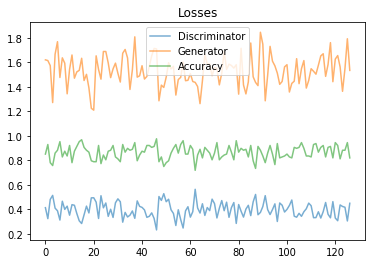

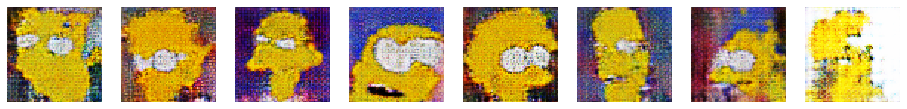

[INFO] Batch 0
[INFO] Batch 20
[INFO] Batch 40
[INFO] Batch 60
[INFO] Batch 80
[INFO] Batch 100
[INFO] Batch 120
Epoch 2/10 
Duration: 43.57391 
D Loss: 0.38498 
G Loss: 1.55090 
D Accuracy: 87.998


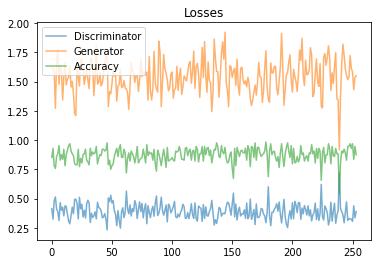

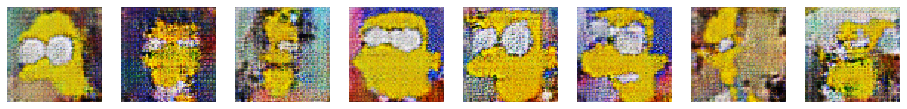

[INFO] Batch 0
[INFO] Batch 20
[INFO] Batch 40
[INFO] Batch 60
[INFO] Batch 80
[INFO] Batch 100
[INFO] Batch 120
Epoch 3/10 
Duration: 43.35273 
D Loss: 0.37747 
G Loss: 1.57793 
D Accuracy: 88.276


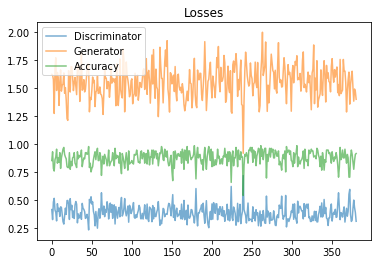

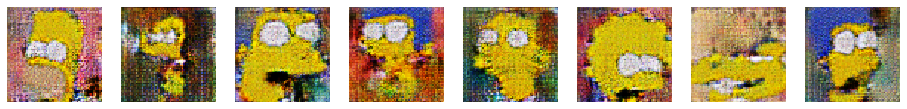

[INFO] Batch 0
[INFO] Batch 20
[INFO] Batch 40
[INFO] Batch 60
[INFO] Batch 80
[INFO] Batch 100
[INFO] Batch 120
Epoch 4/10 
Duration: 43.11979 
D Loss: 0.37162 
G Loss: 1.60048 
D Accuracy: 88.811


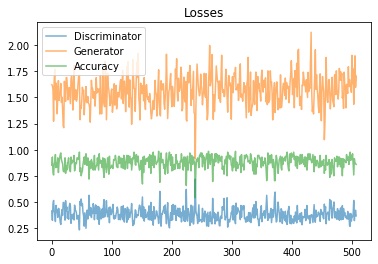

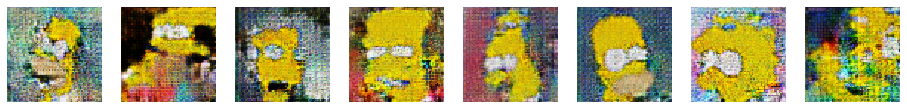

[INFO] Batch 0
[INFO] Batch 20
[INFO] Batch 40
[INFO] Batch 60
[INFO] Batch 80
[INFO] Batch 100
[INFO] Batch 120
Epoch 5/10 
Duration: 42.96900 
D Loss: 0.37533 
G Loss: 1.59627 
D Accuracy: 88.402


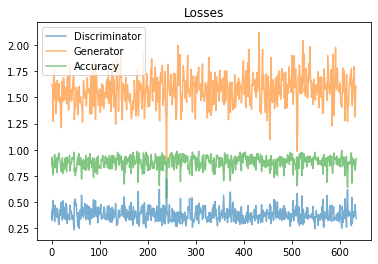

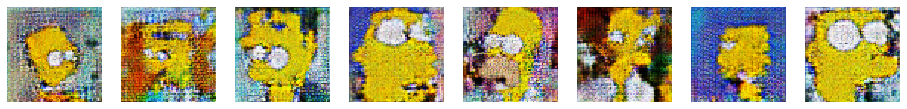

[INFO] Batch 0
[INFO] Batch 20
[INFO] Batch 40
[INFO] Batch 60
[INFO] Batch 80
[INFO] Batch 100
[INFO] Batch 120
Epoch 6/10 
Duration: 43.18458 
D Loss: 0.36405 
G Loss: 1.62344 
D Accuracy: 88.991


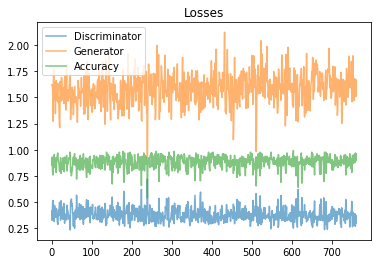

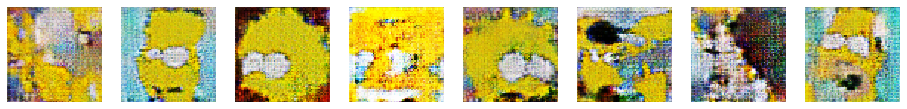

[INFO] Batch 0
[INFO] Batch 20
[INFO] Batch 40
[INFO] Batch 60
[INFO] Batch 80
[INFO] Batch 100
[INFO] Batch 120
Epoch 7/10 
Duration: 42.76251 
D Loss: 0.36267 
G Loss: 1.65123 
D Accuracy: 88.772


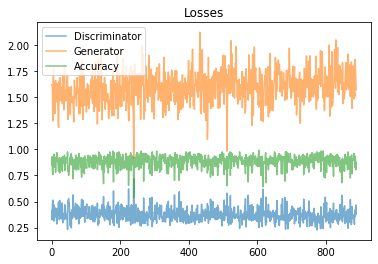

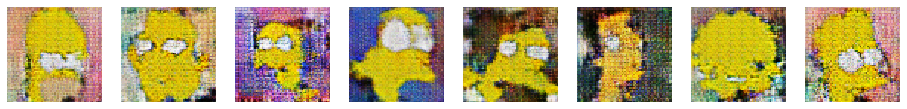

[INFO] Batch 0
[INFO] Batch 20
[INFO] Batch 40
[INFO] Batch 60
[INFO] Batch 80
[INFO] Batch 100
[INFO] Batch 120
Epoch 8/10 
Duration: 43.19539 
D Loss: 0.35392 
G Loss: 1.66189 
D Accuracy: 89.956


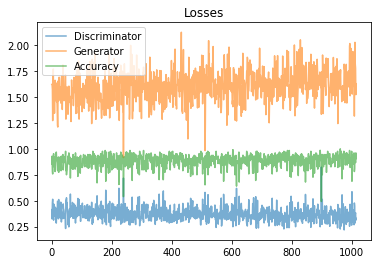

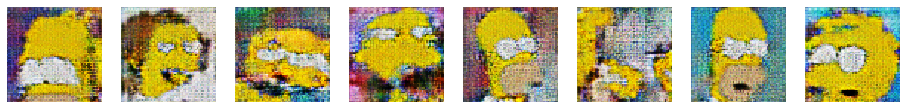

[INFO] Batch 0
[INFO] Batch 20
[INFO] Batch 40
[INFO] Batch 60
[INFO] Batch 80
[INFO] Batch 100
[INFO] Batch 120
Epoch 9/10 
Duration: 43.52084 
D Loss: 0.35057 
G Loss: 1.67094 
D Accuracy: 89.998


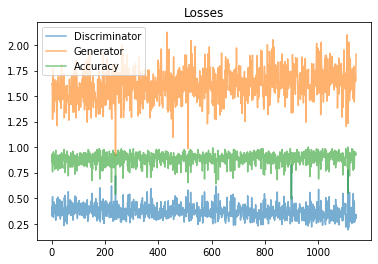

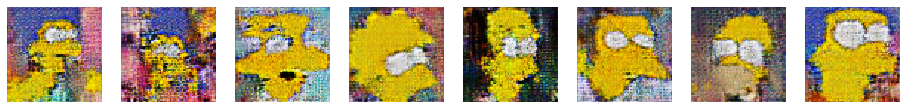

[INFO] Batch 0
[INFO] Batch 20
[INFO] Batch 40
[INFO] Batch 60
[INFO] Batch 80
[INFO] Batch 100
[INFO] Batch 120
Epoch 10/10 
Duration: 42.71648 
D Loss: 0.34390 
G Loss: 1.70567 
D Accuracy: 90.302


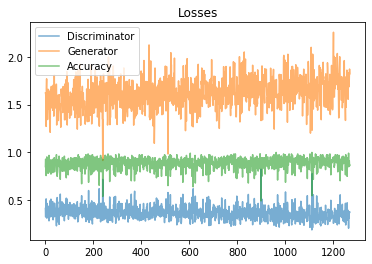

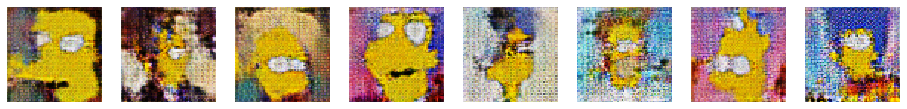

CPU times: user 4min 31s, sys: 56.8 s, total: 5min 28s
Wall time: 7min 19s


In [0]:
%%time
train(EPOCHS, BATCH_SIZE)

<br>
<br>

## Simpsons generados
[[back to top](#Índice)]

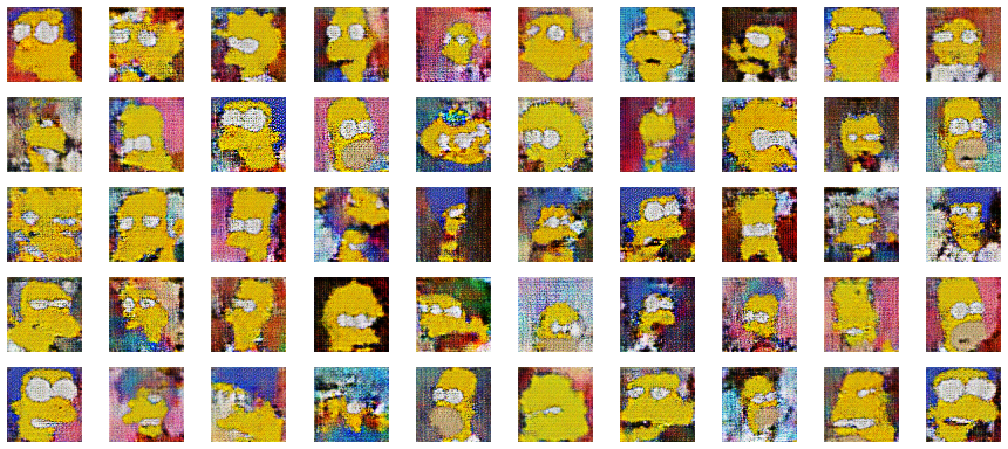

In [0]:
def show_samples2(sample_images):
    figure, axes = plt.subplots(5, 10, figsize = (18, 8))
    i = 0
    for row in axes:
      for col in row:
        col.axis('off')
        col.imshow(sample_images[i])
        i += 1

    plt.show()
    plt.close()

def test2(input_z, SAMPLES_TO_SHOW):
    samples = generator.predict(input_z[:SAMPLES_TO_SHOW])
    sample_images = [((sample + 1.0) * 127.5).astype(np.uint8) for sample in samples]
    show_samples2(sample_images)

noise = np.random.normal(0, 1, size=(51, 100))
test2(noise, 50)

Finalmente después de 50 épocas nuestros vectores aleatorios parecen asemejarse un poco más a los personajes de Los Simpsons. Para mejorar el resultado (que sin duda es muy mejorable) solo hacen falta más épocas.

<br>
<br>

# Referencias
[[back to top](#Índice)]

* [Generative Dog Images](https://www.kaggle.com/c/generative-dog-images)
* [Implementing a Generative Adversarial Network (GAN/DCGAN) to Draw Human Faces](https://towardsdatascience.com/implementing-a-generative-adversarial-network-gan-dcgan-to-draw-human-faces-8291616904a)
* [Deeper into DCGANs](https://towardsdatascience.com/deeper-into-dcgans-2556dbd0baac)
* [Simpsons Faces](https://www.kaggle.com/kostastokis/simpsons-faces)